In [1]:
import numpy as np
from numpy.linalg import inv
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Common Functions

In [2]:
def Zscore(x):
    return (x.to_numpy() - x.mean())/x.std() #* (len(x)/(len(x) - 1)) ** 0.5)
#Since we're using std() from pandas, which normalizes wrt 'N-1' by default, there's no need to modify the code
#https://www.geeksforgeeks.org/python-pandas-series-std/#:~:text=std()%20function%20return%20sample,changed%20using%20the%20ddof%20argument

In [3]:
#Function for data cleaning-normalizing, etc
def cleanup(a, b):
    aT = a['Temp of Water']#Using numbers instead of actual coloumn headers doesn't work
    aL = a['Length of Fish']
    bT = b['Temp of Water']
    bL = b['Length of Fish']
    aT_z = Zscore(aT)
    aL_z = Zscore(aL)
    bT_z = Zscore(bT)
    bL_z = Zscore(bL)
    
    #First dataset(training set)
    bias_a = np.ones(aT.shape[0]).reshape(-1, 1)
    aX = np.append(bias_a, aT_z.reshape(-1, 1), axis = 1)#The X matrix
    aX = np.append(aX, aL_z.reshape(-1, 1), axis = 1)
    aY = a['Age'].to_numpy()#The Y matrix
    
    #Second dataset(test/validation set)
    bias_b = np.ones(bT.shape[0]).reshape(-1, 1)
    bY = b['Age'].to_numpy()
    bX = np.append(bias_b, bT_z.reshape(-1, 1), axis = 1)
    bX = np.append(bX, bL_z.reshape(-1, 1), axis = 1)
    return aX, aY, bX, bY

Reading the data

In [4]:
f = pd.read_csv('x06Simple.csv')#csv reader from pandas library
del f['Index']#We don't need index
random.seed(0)#As  instructed
f.head()

,Age,Temp of Water,Length of Fish
0,14,25,620
1,28,25,1315
2,41,25,2120
3,55,25,2600
4,69,25,3110


# Closed form Linear Regression

In [5]:
training_set, test_set = train_test_split(f, train_size = 0.33)#using 1/3rd data for training
training_set.head()#Testing

,Age,Temp of Water,Length of Fish
14,55,27,2805
27,83,29,3920
7,111,25,4465
3,55,25,2600
17,97,27,4315


In [6]:
trainingX, trainingY, testX, originalY = cleanup(training_set, test_set)
testX#Testing

array([[ 1.        , -0.51313259, -0.5983598 ],
       [ 1.        , -1.4186607 ,  0.65629146],
       [ 1.        , -0.51313259, -1.6192678 ],
       [ 1.        , -1.4186607 , -1.6227052 ],
       [ 1.        ,  0.39239551,  1.08940394],
       [ 1.        ,  1.29792362, -0.73241842],
       [ 1.        , -1.4186607 ,  0.08912034],
       [ 1.        ,  0.39239551,  0.64597925],
       [ 1.        ,  0.39239551,  1.05846734],
       [ 1.        , -1.4186607 , -1.14490651],
       [ 1.        ,  1.29792362,  0.02724713],
       [ 1.        , -0.51313259,  1.11346575],
       [ 1.        ,  0.39239551, -1.64332961],
       [ 1.        , -0.51313259,  1.06877954],
       [ 1.        ,  1.29792362, -0.57773539],
       [ 1.        , -1.4186607 ,  1.06534214],
       [ 1.        ,  1.29792362, -1.22052932],
       [ 1.        , -0.51313259,  1.04128033],
       [ 1.        ,  1.29792362, -1.64332961],
       [ 1.        ,  1.29792362,  0.03412193],
       [ 1.        , -1.4186607 ,  1.113

In [7]:
X_T = np.transpose(trainingX)
X_T_X = np.dot(X_T, trainingX)
X_T_X_inv = np.linalg.inv(X_T_X)
X_T_Y = np.dot(X_T, trainingY)
fx = np.dot(X_T_X_inv, X_T_Y)#output as function of 'x'
fx

array([97.07142857, 21.92934583, 28.88195271])

In [8]:
newY = np.dot(testX, fx)
rmse = mean_squared_error(originalY, abs(newY), squared = False)
print('RMSE is %f'%rmse)

RMSE is 37.303466


# S-fold Cross Validation

In [11]:
def Sfold(dataset, s):
    err_li = []
    #print(s/len(dataset))
    for i in range(20):
        #Since we need average of 20 errors
        random.seed(0)#Each iteration will have randomly shuffled data
        dx = dataset.sample(frac = 1).reset_index()#Selecting sample 'dx'
        k = np.array_split(dx, s)#Selecting the fold
        training_set, test_set = train_test_split(dataset, train_size = s/len(dataset))#Splitting the given dataset accrodingly
        
        #Same thing again
        trainingX, trainingY, testX, originalY = cleanup(training_set, test_set)
        X_T = np.transpose(trainingX)
        X_T_X = np.dot(X_T, trainingX)
        X_T_X_inv = np.linalg.inv(X_T_X)
        X_T_Y = np.dot(X_T, trainingY)
        fx = np.dot(X_T_X_inv, X_T_Y)#output as function of 'x'
        newY = np.dot(testX, fx)
        
        err_li.append(mean_squared_error(originalY, abs(newY), squared = False))
    return err_li

In [12]:
S = [4, 11, 22]
#Index error for the last bit, i.e. S = sample size, couldn't figure out what was wrong so gave up on it
for i in S:
    rmse_li = Sfold(f, i)
    std = np.std(rmse_li)
    mean = np.mean(rmse_li)
    print('For S = {}, average RMSE is {:.4f} with standard deviation {:.4f}'.format(i, mean, std))

For S = 4, average RMSE is 35.4609 with standard deviation 14.4939
For S = 11, average RMSE is 27.5232 with standard deviation 6.2387
For S = 22, average RMSE is 24.8623 with standard deviation 3.0945


Sfold function gives runtime errors sometimes, I think that has something to do with mean_squared_error() function from scikit library. Just run the above two cells again and it should work.

Also rmse and std values for S = 4 vary a lot, not fully sure if they should. Standard deviation generally reduces with increased fold size.

***`Common part for next two problems:`***

*Restart from here for next run, for both next problems, you may want to because sometimes the plots for RMSEs overlap*

In [13]:
random.seed(0)#As said in the pdf
randomized_data = f.sample(frac = 1).reset_index()
#randomized_data.head()
samples = np.array_split(randomized_data, 3)#We need 2/3rd of data, hencce dividing data in 3 different parts
#samples
validation_data = pd.DataFrame(samples[2])#Selecting last 1/3rd data for validation
training_data = pd.DataFrame(randomized_data, index = set(randomized_data.index).difference(set(samples[0].index)))#samples[1] + samples[2]
#print(training_data)
#print(validation_data)

In [14]:
trainingX, trainingY, testX, originalY = cleanup(training_data, validation_data)#Same thing again
#trainingX, testX
#trainingY

#  Locally Weighted Linear Regression

In [15]:
error = []
#Since k = 1, denominator becomes 1, hence ignoring it in the code
for i in range(len(validation_data)):
    temp = []
    for j in range(len(training_data)):
        beta_function = math.exp(-(np.sum(np.abs(testX[i, :]) - np.abs(trainingX[j, :]))))#e^dist
        temp.append(beta_function)
    temp2 = np.diag(np.array(temp))
    xT = np.transpose(trainingX)
    fx = np.linalg.inv(xT.dot(temp2).dot(trainingX)).dot(xT.dot(temp2).dot(trainingY))#I really should've created a function for this!!
    prediction = np.dot(trainingX[i], fx)#prediction for each local value
    
    sq_error = (abs(prediction) - originalY[i])**2#Computing squared errors, as instructed, here mean_squared_error() function did not work
    error.append(sq_error)
rmse = np.sqrt(np.sum(error) / len(error))
print(f'RMSE is {rmse:.4f}')

RMSE is 62.7482


# Gradient Descent

In [16]:
eta = 0.0001#Given
epoch_limit = 1000000#Also given
size = trainingX.shape[1]
fx = np.random.uniform(-eta, eta, size)#For uniform distribution
fx

array([2.47226962e-05, 3.08577327e-05, 5.28523331e-05])

In [17]:
prediction_training_data = np.dot(trainingX, fx)
prediction_test_data = np.dot(testX, fx)
prediction_training_data, prediction_test_data#Testing

(array([-3.41962448e-05,  9.10279795e-05, -4.89070785e-05,  1.56327330e-05,
         9.33478332e-05, -7.67932010e-05,  5.09423874e-05,  3.56313527e-05,
        -1.66611116e-05, -5.79066305e-05,  5.00144459e-05, -5.45226051e-05,
        -3.08600970e-05,  5.04784167e-05,  3.94793489e-05,  6.36058278e-05,
         6.34217200e-05,  5.90154784e-05,  3.20079394e-05,  6.66216377e-05,
         4.21757208e-06,  3.68796322e-05,  6.17499448e-05,  9.33942303e-05,
         5.74379779e-05,  6.34217200e-05,  3.50237492e-05,  9.12599649e-05,
        -1.17806735e-04]),
 array([ 4.53703567e-05,  4.60822694e-05,  4.23707537e-05,  1.13612071e-05,
         4.85299485e-05, -1.68492975e-05,  1.64651631e-05,  4.34259925e-05,
         7.74837511e-05,  4.07180441e-05,  4.60822694e-05,  1.45207989e-05,
         7.52477323e-05, -1.44691243e-04]))

In [18]:
#Starting points for rmse graphs
rmse_training = np.sqrt(((prediction_training_data - trainingY)**2).mean())
rmse_test = np.sqrt(((prediction_test_data - originalY)**2).mean())
rmse_training, rmse_test#Testing

(97.86651137606576, 116.4942923937792)

In [19]:
count = 0
percent_change = 1

rmse_training_li = [rmse_training]
rmse_test_li = [rmse_test]
while count < epoch_limit:
    fx  = fx - 2 * eta * (trainingX.T.dot(trainingX.dot(fx) - trainingY))
    
    #For training rmse
    prediction_training_data = trainingX.dot(fx)
    rmse_training_tmp = np.sqrt(((prediction_training_data - trainingY) ** 2).mean())
    rmse_training_li.append(rmse_training_tmp)
    
    #For validation rmse
    prediction_test_data = testX.dot(fx)
    rmse_test_tmp = np.sqrt(((prediction_test_data - originalY) ** 2).mean())
    rmse_test_li.append(rmse_test_tmp)
    
    #percent_change = np.abs((rmse_training_tmp - rmse_training) / rmse_test)
    #rmse_training = rmse_training_tmp
    
    count += 1

*Ignoring percent change and directly using 1000000 epoches, it's just easier to manually putting a cap on valules in the plot below*

In [20]:
print(fx)
print(count)
rmse_training_li[:20]#Test

[89.37931034  9.39968017 35.08894864]
1000000


[97.86651137606576,
 97.33086864661487,
 96.79846012625107,
 96.26926767890166,
 95.74327327662446,
 95.22045899895815,
 94.70080703227542,
 94.18429966913997,
 93.67091930766682,
 93.16064845088563,
 92.65346970610777,
 92.14936578429628,
 91.64831949943934,
 91.15031376792686,
 90.6553316079303,
 90.1633561387857,
 89.67437058037972,
 89.18835825253912,
 88.70530257442292,
 88.22518706391809]

In [21]:
rmse_test_li[:20]#Test

[116.4942923937792,
 115.96201992629595,
 115.43296130482918,
 114.90709813061437,
 114.38441211063412,
 113.864885056968,
 113.34849888614644,
 112.83523561850815,
 112.32507737756141,
 111.81800638934908,
 111.31400498181742,
 110.81305558418842,
 110.31514072633598,
 109.82024303816571,
 109.32834524899836,
 108.83943018695687,
 108.35348077835715,
 107.87048004710223,
 107.39041111408027,
 106.9132571965659]

Plotting RMSEs

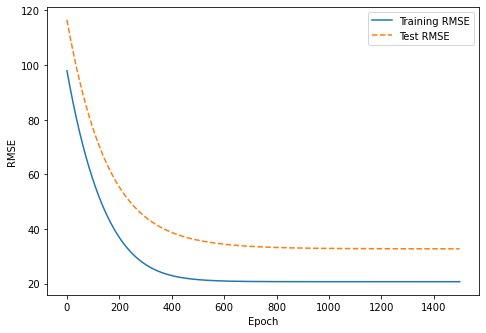

In [22]:
%matplotlib inline
#Suggested by the internet

tmp = plt.figure()
fig = tmp.add_axes([0, 0, 1, 1])
fig.plot([i for i in range(1500)], rmse_training_li[:1500], label = 'Training RMSE')
fig.plot([i for i in range(1500)], rmse_test_li[:1500], label = 'Test RMSE', linestyle = 'dashed')
fig.set_xlabel('Epoch')
fig.set_ylabel('RMSE')
fig.legend()

After 1500 values, both training RMSE and test RMSE plots become nearly straight lines and it also becomes hard to distinguish between the two plots afterwards, hence showing only 1500 values.